# pySCENIC - Developmental Mouse Habenula Data 

This notebook is a modification of the original notebook from:
__Author:__ Bram Van de Sande
__Date:__ 6 AUG 2019
__Outline:__ Acquistion and cleaning of selected scRNAseq data sets.

__Author:__ Lieke L. van de Haar 
New elements from other pyscenic notebooks are integrated for downstream analysis, while some new processing steps (e.g. leiden from scanpy) and visualisation steps are integrated


In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

#from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.export import add_scenic_metadata

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Set maximum number of jobs
sc.settings.njobs = 32

In [3]:
RESOURCES_FOLDERNAME = "../../data/output/pySCENIC/"
RESULTS_FOLDERNAME = "../../data/output/pySCENIC/"
FIGURES_FOLDERNAME = "../../figures/pySCENIC/"
AUXILLIARIES_FOLDERNAME = "../../data/input/pySCENIC/"
sc.settings.figdir = "../../figures/pySCENIC"

In [4]:
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       [#'mm9-500bp-upstream-10species.mc9nr.feather',
                       #'mm9-tss-centered-10kb-10species.mc9nr.feather',
                       # 'mm9-tss-centered-5kb-10species.mc9nr.feather',
                       'mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather']))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')

__CLEANING METADATA AND QC__

In [18]:
DATASET_ID = 'embryo_hb'

In [19]:
# Downloaded expression matrix from GEO on 13 JUN 2019 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361).
#COUNTS_MTX_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'GSE60361_C1-3005-Expression.txt')
# Downloaded metadata from http://linnarssonlab.org/cortex/ on 13 JUN 2019
#METADATA_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'expression_mRNA_17-Aug-2014.txt')

#MM_TFS_FNAME = os.path.join(RESOURCES_FOLDERNAME, './results/mm_tfs.txt') #RESULTS_FOLDERNAME

# Output file
COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.counts.csv')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.loom'.format(DATASET_ID))

__Load filtered and normalized data which is used as input for pySCENIC__ 
Normalization does not affect the outcome of pySCENIC (ref Aibar) so we ran pySCENIC on the filtered and normalized expression matrix

In [1]:
import pandas as pd

In [2]:
test = pd.read_csv("../../data/output/pySCENIC/Mar2020_pyscenic_input_raw_2.csv")

In [3]:
test

Unnamed: 0     Gnai3  Cdc45  H19  Scml2  Apoh  \
0       Habenula_012___E11_1__X009  1.543396    0.0  0.0    0.0   0.0   
1       Habenula_012___E11_1__X011  1.217313    0.0  0.0    0.0   0.0   
2       Habenula_012___E11_1__X012  1.611092    0.0  0.0    0.0   0.0   
3       Habenula_012___E11_1__X013  1.762691    0.0  0.0    0.0   0.0   
4       Habenula_012___E11_1__X014  0.471373    0.0  0.0    0.0   0.0   
...                            ...       ...    ...  ...    ...   ...   
2768  Habenula_017___adult_2__X283  0.372907    0.0  0.0    0.0   0.0   
2769  Habenula_017___adult_2__X285  0.538686    0.0  0.0    0.0   0.0   
2770  Habenula_017___adult_2__X286  0.000000    0.0  0.0    0.0   0.0   
2771  Habenula_017___adult_2__X287  0.566183    0.0  0.0    0.0   0.0   
2772  Habenula_017___adult_2__X288  0.615460    0.0  0.0    0.0   0.0   

          Narf      Cav2      Klf6     Scmh1  ...  AC034116.5  AC154242.1  \
0     0.000000  0.000000  0.000000  0.000000  ...         0.0         0.0   
1     0.000000  0.000000  0.000000  1.428200  ...         0.0         0.0   
2     1.387753  0.000000  1.099827  1.099827  ...         0.0         0.0   
3     0.675568  0.000000  0.000000  1.075184  ...         0.0         0.0   
4     0.000000  0.000000  1.226610  1.032123  ...         0.0         0.0   
...        ...       ...       ...       ...  ...         ...         ...   
2768  0.000000  0.372907  0.372907  0.857042  ...         0.0         0.0   
2769  0.000000  0.000000  0.887008  1.438564  ...         0.0         0.0   
2770  0.000000  0.000000  1.137028  1.655461  ...         0.0         0.0   
2771  0.000000  0.000000  1.066269  0.322604  ...         0.0         0.0   
2772  0.615460  0.000000  0.822383  0.993782  ...         0.0         0.0   

      CT030713.2  AC150035.3  AC164314.2  AC131339.4  AC109255.2  AC135964.2  \
0            0.0         0.0    0.000000         0.0         0.0         0.0   
1            0.0         0.0    0.949805         0.0         0.0         0.0   
2            0.0         0.0    0.000000         0.0         0.0         0.0   
3            0.0         0.0    0.000000         0.0         0.0         0.0   
4            0.0         0.0    0.000000         0.0         0.0         0.0   
...          ...         ...         ...         ...         ...         ...   
2768         0.0         0.0    0.372907         0.0         0.0         0.0   
2769         0.0         0.0    0.000000         0.0         0.0         0.0   
2770         0.0         0.0    0.000000         0.0         0.0         0.0   
2771         0.0         0.0    0.322604         0.0         0.0         0.0   
2772         0.0         0.0    0.000000         0.0         0.0         0.0   

      AC110534.5  CT030736.1  
0       0.000000         0.0  
1       0.000000         0.0  
2       0.000000         0.0  
3       0.000000         0.0  
4       0.000000         0.0  
...          ...         ...  
2768    0.000000         0.0  
2769    0.538686         0.0  
2770    0.000000         0.0  
2771    0.000000         0.0  
2772    0.354313         0.0  

[2773 rows x 30453 columns]

In [17]:
adata_pre = sc.read("../../data/output/pySCENIC/Mar2020_pySCENIC_input_norm.h5ad")

In [18]:
adata_pre 

AnnData object with n_obs × n_vars = 2773 × 30452
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

__Load the complete adata that is used for all downstream analyses, which is filtered for highly variable genes and contains all metadata__

In [13]:
adata = sc.read('../../data/output/embryo_hb/Mar2020_embryo_Hb_Pou4f1_louvain_seurat.h5ad') ## processed data, should we use the Seurat integrated data here? This one has the correct clusters

In [14]:
adata

AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'plate_colors', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

### STEP 1: Network inference based on GRNBoost2 from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

In [27]:
MOTIFS_FNAME = '../../data/output/pySCENIC/embryo_hb.motifs.csv' 

In [28]:
df_motifs = load_motifs(MOTIFS_FNAME)

In [29]:
df_motifs.shape #(968, 8)

(968, 8)

### STEP 4: Cellular enrichment aka AUCell

__REGULON CREATION__

Regulons can easily be created from this list of enriched motifs via `pyscenic.transform.df2regulons`. Here we provide an auxilliary function to carefully select the enriched motifs that contribute to the regulons.

In [30]:
def derive_regulons(mt, db_names=('../../data/input/pySCENIC/mm9-tss-centered-5kb-10species.mc9nr')):
    def contains(*elems):
            def f(context):
                return any(elem in context for elem in elems)
            return f
    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = mt['Enrichment']
    motifs = motifs[np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool)  & \
        np.fromiter(map(contains('mm9-tss-centered-5kb-10species.mc9nr'), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10,df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                          & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                            | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                               & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                            ])))
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))


In [31]:
#regulons = df2regulons(df_motifs)

In [32]:
regulons = derive_regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


__AUCELL__ add the regulons to the raw adata_pre file 

In [33]:
adata_pre #adata_raw

AnnData object with n_obs × n_vars = 2773 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [34]:
df_counts_qc = adata_pre.to_df()

Define auc_mtx first

In [ ]:
%%time
auc_mtx = aucell(df_counts_qc, regulons, num_workers=32) #exp_mtx is df_counts_qc, or adata.to_df()
auc_mtx.to_csv(AUCELL_MTX_FNAME)

In [ ]:
auc_mtx.to_csv(AUCELL_MTX_FNAME)

```
CPU times: user 10.5 s, sys: 4.41 s, total: 14.9 s
Wall time: 14 s
```

In [21]:
# To read from the file
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)

__AUCELL + tSNE PROJECTION__

We add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [25]:
adata.write("../../data/output/pySCENIC/embryo_hb_pyscenic.h5ad")

In [22]:
adata 

AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'plate_colors', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [33]:
add_scenic_metadata(adata, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain', 'Regulon(Atf3)', 'Regulon(Cebpb)', 'Regulon(Cux2)', 'Regulon(Elk3)', 'Regulon(Ets1)', 'Regulon(Ezh2)', 'Regulon(Fli1)', 'Regulon(Gli1)', 'Regulon(Hdac6)', 'Regulon(Irf5)', 'Regulon(Irf7)', 'Regulon(Irf8)', 'Regulon(Lhx2)', 'Regulon(Mef2d)', 'Regulon(Nfic)', 'Regulon(Nr1d1)', 'Regulon(Nr2e1)', 'Regulon(Onecut3)', 'Regulon(Pou3f2)', 'Regulon(Pou3f4)', 'Regulon(Rarg)', 'Regulon(Sox11)', 'Regulon(Sox4)', 'Regulon(Spi1)', 'Regulon(Srebf2)', 'Regulon(Tcf7l1)'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', '

__Create new tSNE coordinates based on regulons per cell__

In [28]:
sc.tl.tsne(adata, use_rep='X_aucell')

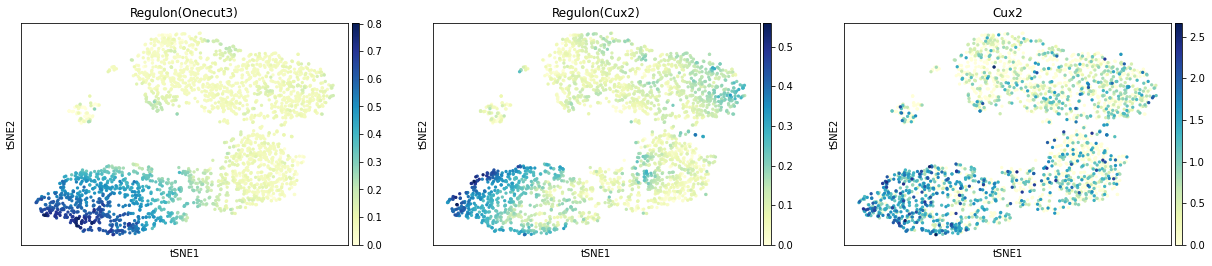

In [42]:
sc.pl.tsne(adata, color=['Regulon(Onecut3)', 'Regulon(Cux2)', 'Cux2'], cmap="YlGnBu", ncols=3)

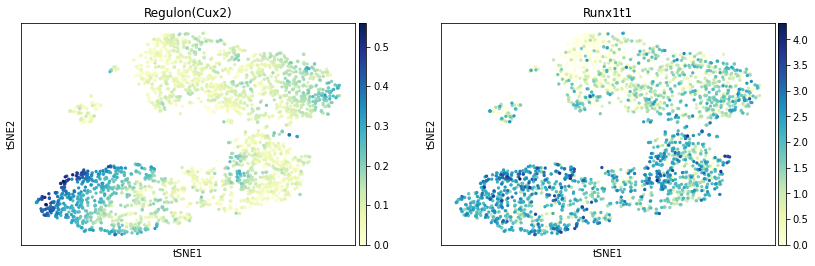

In [41]:
sc.pl.tsne(adata, color=['Regulon(Cux2)', 'Runx1t1'], cmap="YlGnBu", ncols=3)

In [33]:
adata.uns['umap_original'] = adata.uns['umap']

In [10]:
adata

AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain', 'Regulon(Atf3)', 'Regulon(Cebpb)', 'Regulon(Cux2)', 'Regulon(Elk3)', 'Regulon(Ets1)', 'Regulon(Ezh2)', 'Regulon(Fli1)', 'Regulon(Gli1)', 'Regulon(Hdac6)', 'Regulon(Irf5)', 'Regulon(Irf7)', 'Regulon(Irf8)', 'Regulon(Lhx2)', 'Regulon(Mef2d)', 'Regulon(Nfic)', 'Regulon(Nr1d1)', 'Regulon(Nr2e1)', 'Regulon(Onecut3)', 'Regulon(Pou3f2)', 'Regulon(Pou3f4)', 'Regulon(Rarg)', 'Regulon(Sox11)', 'Regulon(Sox4)', 'Regulon(Spi1)', 'Regulon(Srebf2)', 'Regulon(Tcf7l1)'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', '

In [34]:
sc.tl.umap(adata, init_pos='X_aucell')

In [36]:
adata.write("../../data/output/pySCENIC/embryo_hb_pyscenic.h5ad")

# Downstream analysis

In [7]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
from scanpy.plotting._tools.scatterplots import _wraps_plot_scatter as plot_scatter
import seaborn as sns

Can load hte loom file. However, the file saved above doesnt contain much info...

In [8]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
#f_final_loom= 'Lepr_hypothalamus_agrpneurons_down8000_unfiltered.loom'

In [9]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1


Read from adata

In [9]:
#Use this to restart
adata = sc.read("../../data/output/pySCENIC/embryo_hb_pyscenic.h5ad", validate=False)

In [10]:
adata

AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain', 'Regulon(Atf3)', 'Regulon(Cebpb)', 'Regulon(Cux2)', 'Regulon(Elk3)', 'Regulon(Ets1)', 'Regulon(Ezh2)', 'Regulon(Fli1)', 'Regulon(Gli1)', 'Regulon(Hdac6)', 'Regulon(Irf5)', 'Regulon(Irf7)', 'Regulon(Irf8)', 'Regulon(Lhx2)', 'Regulon(Mef2d)', 'Regulon(Nfic)', 'Regulon(Nr1d1)', 'Regulon(Nr2e1)', 'Regulon(Onecut3)', 'Regulon(Pou3f2)', 'Regulon(Pou3f4)', 'Regulon(Rarg)', 'Regulon(Sox11)', 'Regulon(Sox4)', 'Regulon(Spi1)', 'Regulon(Srebf2)', 'Regulon(Tcf7l1)'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', '

In [47]:
# To read from the file
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)

In [12]:
#Use this to restart from loom 
#adata = sc.read( f_final_loom, validate=False) #from loom
# drop the embeddings and extra attributes from the obs object
#adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

# Regulon specificity scores (RSS) across predicted cell types

In [48]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### Calculate RSS

In [49]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs['stage'] )
rss_cellType

Atf3     Cebpb      Cux2      Elk3      Ets1      Ezh2      Fli1  \
E11    0.280287  0.248993  0.414198  0.301228  0.318392  0.416002  0.331734   
E12    0.223724  0.206656  0.314822  0.260886  0.254808  0.284981  0.260178   
E13    0.214571  0.207918  0.205788  0.258690  0.280299  0.260626  0.250171   
E15    0.239198  0.206229  0.252883  0.285169  0.291792  0.342578  0.303054   
E18    0.212008  0.204111  0.230516  0.250490  0.235630  0.244960  0.254794   
P4     0.223384  0.206806  0.314597  0.270627  0.291787  0.288849  0.324850   
P7     0.232105  0.211545  0.303617  0.270079  0.299179  0.270586  0.309267   
adult  0.205093  0.227083  0.223818  0.231749  0.250501  0.205141  0.248741   

           Gli1     Hdac6      Irf5  ...     Nr2e1   Onecut3    Pou3f2  \
E11    0.211059  0.356070  0.179886  ...  0.246102  0.535128  0.399672   
E12    0.254359  0.277271  0.183382  ...  0.205433  0.317422  0.286189   
E13    0.221966  0.233583  0.187727  ...  0.216927  0.227740  0.253998   
E15    0.215578  0.309119  0.182276  ...  0.237657  0.239100  0.331628   
E18    0.221429  0.229733  0.180005  ...  0.282813  0.198836  0.238608   
P4     0.216405  0.352577  0.177646  ...  0.183519  0.253272  0.306258   
P7     0.205075  0.323838  0.177860  ...  0.181636  0.260367  0.294386   
adult  0.217624  0.210590  0.181822  ...  0.190811  0.199882  0.215322   

         Pou3f4      Rarg     Sox11      Sox4      Spi1    Srebf2    Tcf7l1  
E11    0.422162  0.244544  0.407384  0.394933  0.182792  0.416057  0.363038  
E12    0.290111  0.233019  0.285873  0.284277  0.179791  0.286108  0.277921  
E13    0.245192  0.256407  0.256874  0.254104  0.188554  0.255457  0.271957  
E15    0.319747  0.237316  0.335686  0.334191  0.180662  0.326594  0.305058  
E18    0.234833  0.224827  0.239723  0.240468  0.183663  0.237397  0.261628  
P4     0.301408  0.252661  0.306050  0.311810  0.175360  0.294751  0.292030  
P7     0.285828  0.265006  0.285645  0.293993  0.177217  0.286599  0.278108  
adult  0.215797  0.240209  0.204317  0.212458  0.179662  0.221225  0.221478  

[8 rows x 26 columns]

### RSS panel plot with all cell types

In [50]:
cell_types = adata.obs['stage']

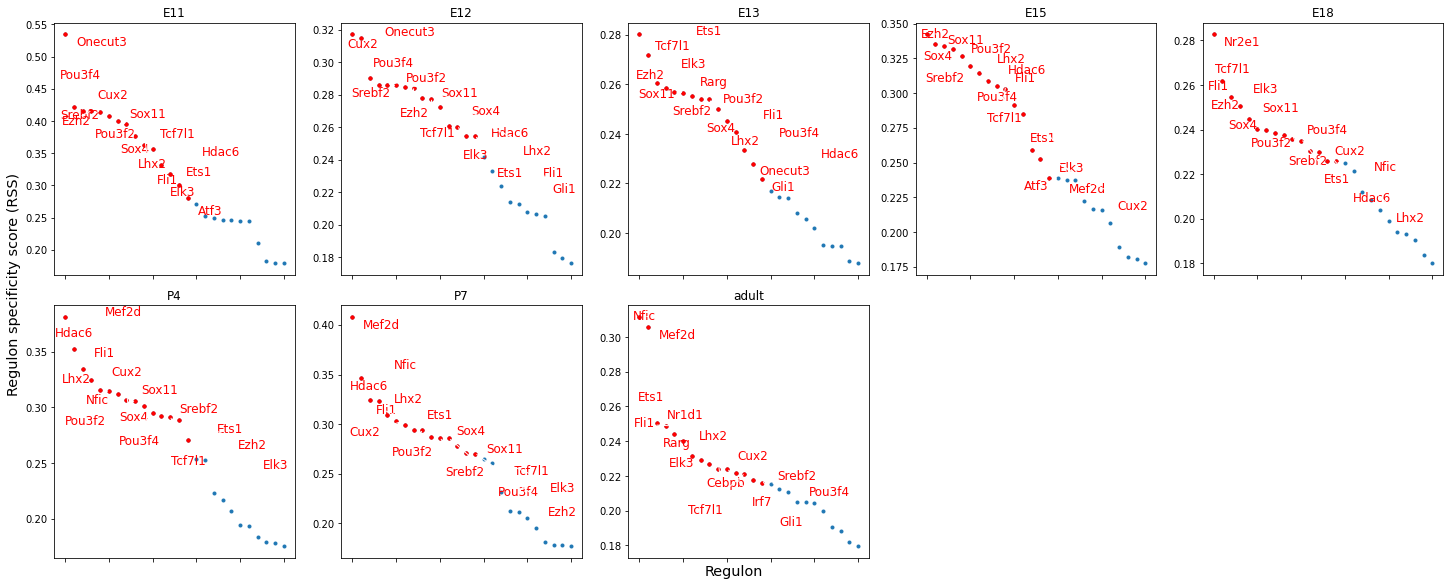

In [51]:
cats = sorted(list(set(cell_types)))

fig = plt.figure(figsize=(20, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=15, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', arrowprops=dict(arrowstyle='-',color='white'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'
        })
plt.savefig("../../figures/pySCENIC/top_regulons_stage.pdf", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [16]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [17]:
topreg

['Nfic',
 'Pou3f4',
 'Onecut3',
 'Sox11',
 'Sox4',
 'Hdac6',
 'Ezh2',
 'Nr2e1',
 'Elk3',
 'Mef2d',
 'Ets1',
 'Pou3f2',
 'Lhx2',
 'Nr1d1',
 'Cux2',
 'Srebf2',
 'Tcf7l1',
 'Fli1']

#### Generate a Z-score for each regulon to enable comparison between regulons

In [18]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)


#### Generate a heatmap

In [24]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [20]:
colors=adata.uns["stage_colors"]
#colors = sns.color_palette('bright',n_colors=len(cats) ) ## change this to colors used in SCANPY 
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cell_types ] #cellAnnot['Celltype_Garnett']

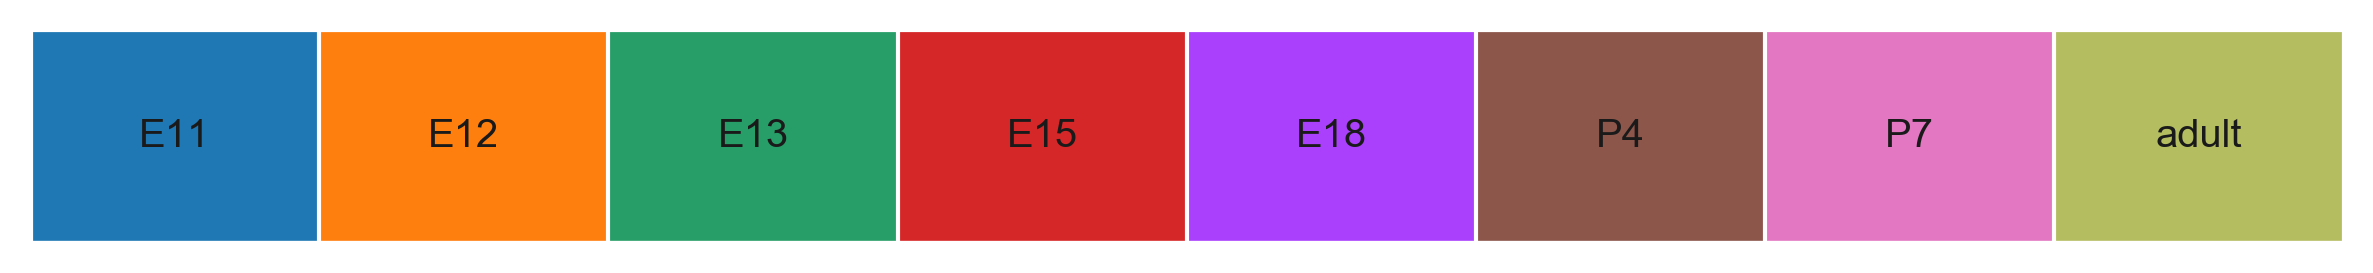

In [21]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

The following takes a long time. May need to use 'fastcluster'

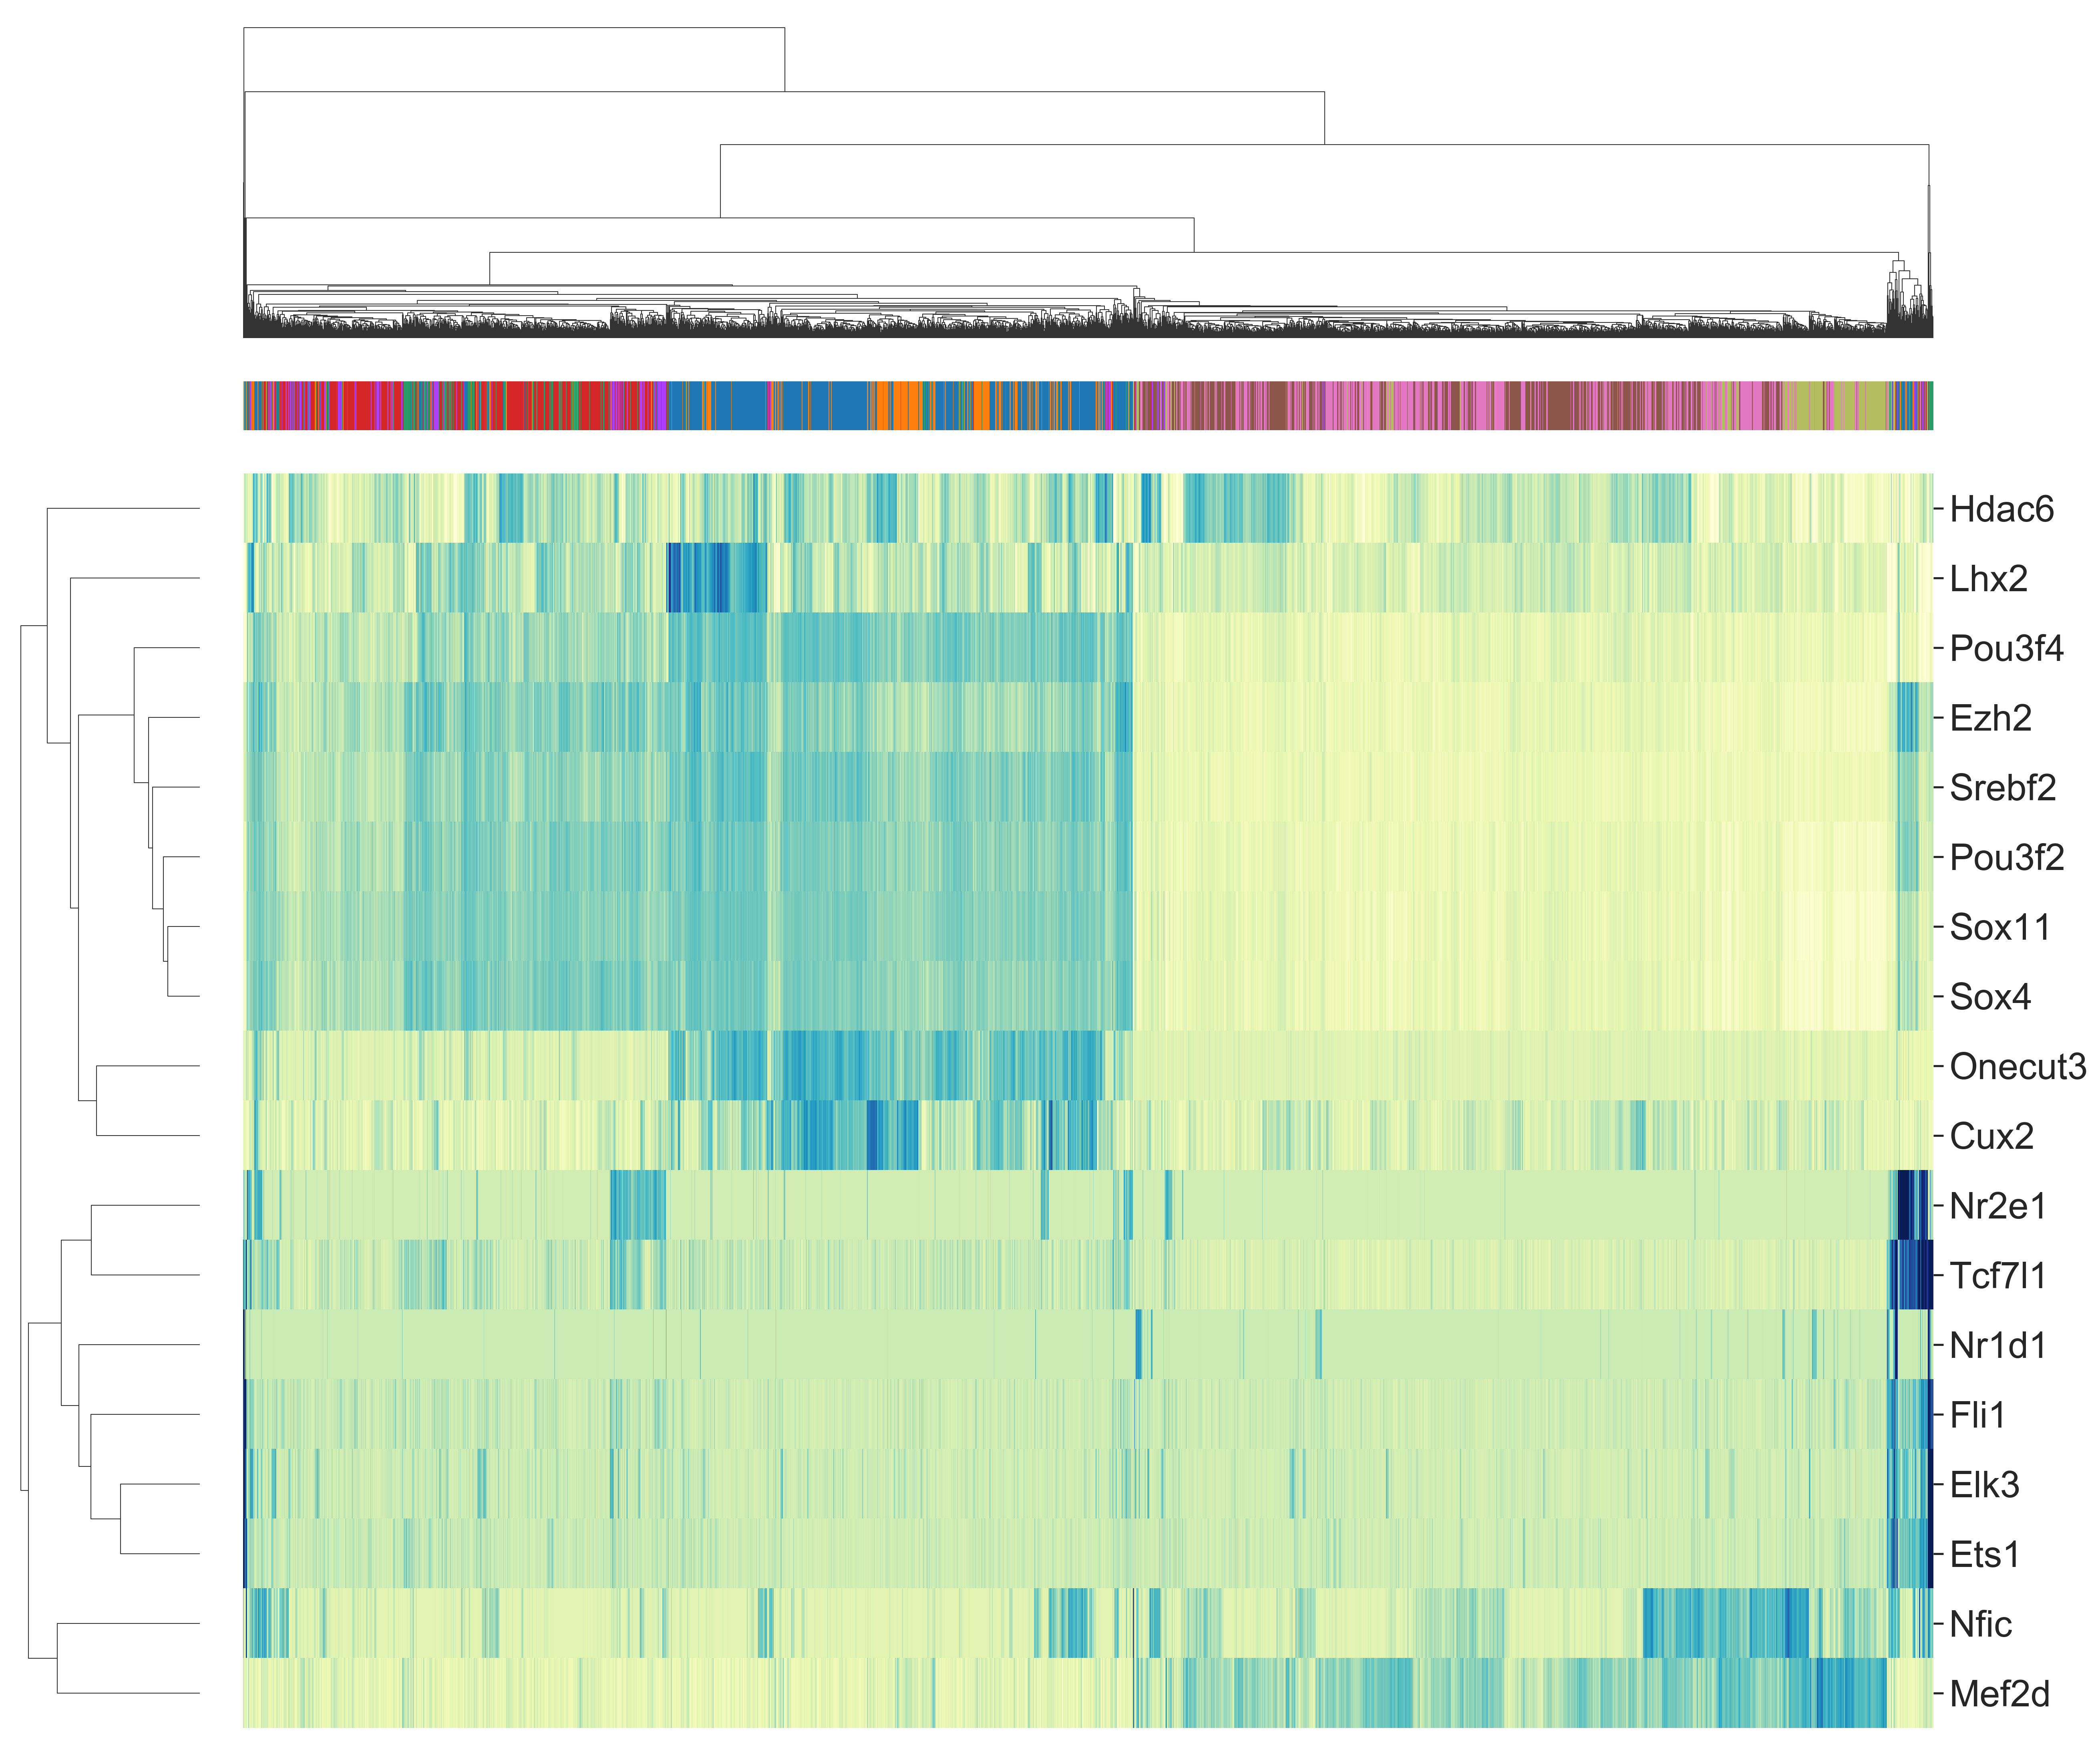

In [39]:
# do not use the 'annot=False,' option in clustermap. 
# Adds numbers in the plot rahter than disabling it. I think this is a bug
sns.set(font_scale=2)
g = sns.clustermap(auc_mtx_Z[topreg].T, square=False,  linecolor='black',
    xticklabels=False, vmin=-2, vmax=6, col_colors=colormap,
    cmap="YlGnBu", figsize=(18,15), dendrogram_ratio=(.1, .2), cbar_pos=None)
#g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 
g.savefig("../../figures/pySCENIC/regulon_heatmap_Z-score.pdf", dpi=100)

### Show the AUC distributions for selected regulons

In [55]:
auc_mtx['Onecut3']


Cell
Habenula_012___E11_1__X009      0.460913
Habenula_012___E11_1__X011      0.000000
Habenula_012___E11_1__X012      0.521317
Habenula_012___E11_1__X013      0.646349
Habenula_012___E11_1__X014      0.592951
                                  ...   
Habenula_017___adult_2__X283    0.036033
Habenula_017___adult_2__X285    0.106469
Habenula_017___adult_2__X286    0.057933
Habenula_017___adult_2__X287    0.058027
Habenula_017___adult_2__X288    0.051382
Name: Onecut3, Length: 2773, dtype: float64

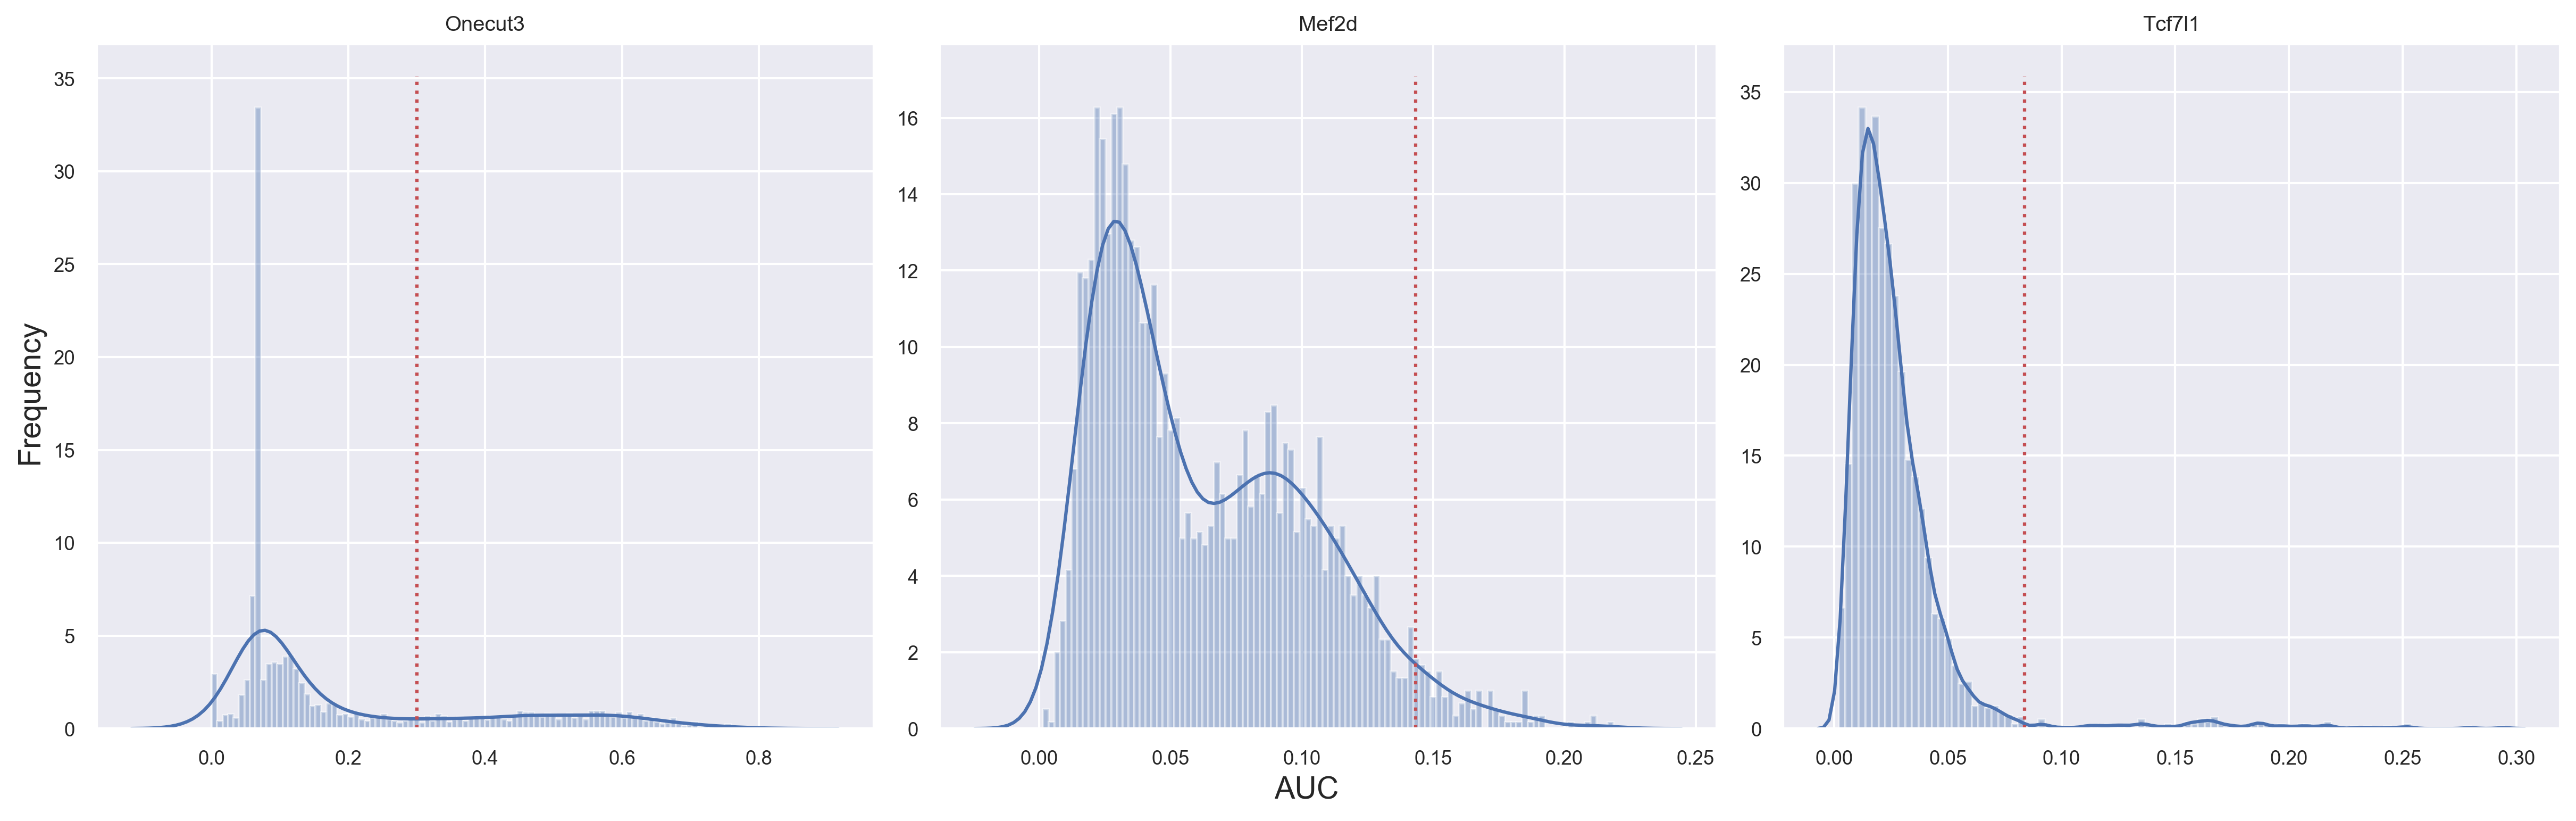

In [57]:
# select regulons:
r = [ 'Onecut3', 'Mef2d', 'Tcf7l1' ]

fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'AUC', ha='center', va='center', rotation='horizontal', size='x-large')

fig.tight_layout()
fig.savefig("binary_plot.png", dpi=150, bbox_inches = "tight")

## Generate sequence logos

In [65]:
from IPython.display import HTML, display
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [77]:
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [92]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [93]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head().to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Stage specific regulators Z-score

In [106]:
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['stage']]
df_results = ((df_scores.groupby(by='stage').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 0.1)].sort_values('Z', ascending=False).head()

stage  regulon         Z
195  adult    Mef2d  1.804443
17     E11  Onecut3  1.553918
19     E11   Pou3f4  1.247721
24     E11   Srebf2  1.239294
28     E12     Cux2  1.100796

Text(8.959999999999999, 0.5, '')

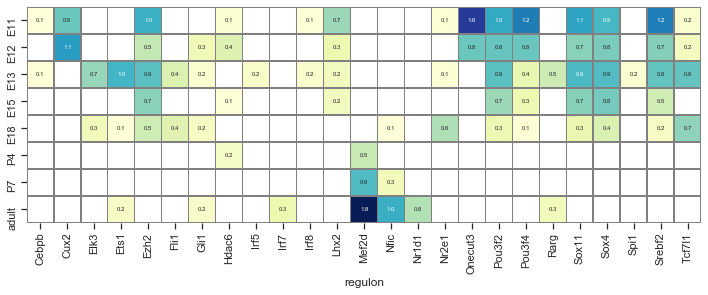

In [110]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 0.1].sort_values('Z', ascending=False),
                           index='stage', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')

---
# Regulon specificity scores (RSS) across Louvain clusters

### Calculate RSS

In [17]:
rss_louvain = regulon_specificity_scores( auc_mtx, adata.obs['louvain'])
rss_louvain

Atf3     Cebpb      Cux2      Elk3      Ets1      Ezh2      Fli1  \
1   0.241272  0.230470  0.346650  0.249494  0.267683  0.330798  0.278779   
12  0.301214  0.208888  0.180879  0.248774  0.259168  0.209458  0.236864   
0   0.234504  0.210901  0.301504  0.264969  0.265676  0.313641  0.279670   
4   0.199535  0.195145  0.321057  0.233214  0.233217  0.277566  0.240949   
8   0.195576  0.188404  0.212800  0.235401  0.232068  0.259283  0.237356   
13  0.206735  0.331721  0.171335  0.302635  0.294073  0.180116  0.249645   
6   0.240182  0.209320  0.219577  0.282454  0.276146  0.288598  0.267925   
11  0.205428  0.177419  0.229305  0.198632  0.205228  0.219226  0.208556   
3   0.208686  0.196365  0.248950  0.233356  0.246909  0.243580  0.267434   
2   0.207987  0.197143  0.266821  0.236752  0.249234  0.252086  0.277333   
5   0.210670  0.198240  0.225933  0.221635  0.234866  0.230358  0.244568   
7   0.185514  0.207194  0.214881  0.219936  0.240967  0.214330  0.233420   
10  0.187029  0.186441  0.210723  0.206423  0.219236  0.208729  0.211953   
9   0.193111  0.189073  0.233332  0.205121  0.208657  0.208110  0.223905   

        Gli1     Hdac6      Irf5  ...     Nr2e1   Onecut3    Pou3f2    Pou3f4  \
1   0.201046  0.306400  0.172848  ...  0.203164  0.409792  0.323674  0.339430   
12  0.375077  0.185986  0.199780  ...  0.441200  0.173356  0.200707  0.184369   
0   0.207983  0.310927  0.177218  ...  0.197273  0.326376  0.315152  0.318111   
4   0.192675  0.267860  0.168707  ...  0.181937  0.324339  0.277505  0.285785   
8   0.198245  0.238572  0.176761  ...  0.215589  0.216017  0.254354  0.249478   
13  0.188108  0.176733  0.433821  ...  0.188735  0.171627  0.178242  0.172815   
6   0.229715  0.239695  0.187274  ...  0.331795  0.235822  0.272345  0.266045   
11  0.217375  0.214259  0.171727  ...  0.175884  0.226086  0.220215  0.218022   
3   0.206679  0.272404  0.173650  ...  0.171745  0.218352  0.253599  0.253741   
2   0.202019  0.285132  0.169611  ...  0.178878  0.224349  0.265112  0.266241   
5   0.186993  0.247379  0.168726  ...  0.172139  0.205434  0.238643  0.233926   
7   0.180832  0.225298  0.168882  ...  0.175455  0.197501  0.220776  0.214390   
10  0.186201  0.219086  0.177756  ...  0.178349  0.201066  0.214687  0.207691   
9   0.180344  0.233837  0.167445  ...  0.167462  0.202298  0.215115  0.220799   

        Rarg     Sox11      Sox4      Spi1    Srebf2    Tcf7l1  
1   0.220633  0.331068  0.322278  0.171852  0.333248  0.293181  
12  0.261451  0.195941  0.197006  0.209330  0.200102  0.286128  
0   0.226162  0.317325  0.315637  0.180291  0.315671  0.291535  
4   0.199134  0.279756  0.276913  0.170637  0.280656  0.254529  
8   0.214642  0.256032  0.254320  0.173517  0.252983  0.242889  
13  0.352621  0.177441  0.176896  0.367817  0.179610  0.225774  
6   0.240170  0.272841  0.273202  0.178486  0.273446  0.295358  
11  0.213118  0.221089  0.220354  0.171246  0.220242  0.216927  
3   0.212545  0.249535  0.255743  0.170555  0.250614  0.242668  
2   0.222980  0.265731  0.266597  0.175571  0.256490  0.255619  
5   0.211985  0.234614  0.237678  0.171528  0.234565  0.215936  
7   0.218144  0.216008  0.220819  0.170718  0.222240  0.210532  
10  0.220506  0.211987  0.215316  0.170385  0.213740  0.204557  
9   0.199869  0.212940  0.216310  0.168140  0.212353  0.210398  

[14 rows x 26 columns]

### RSS panel plot with all cell types

In [16]:
sns.set(font_scale=0.8)

In [18]:
clusters = adata.obs['louvain']

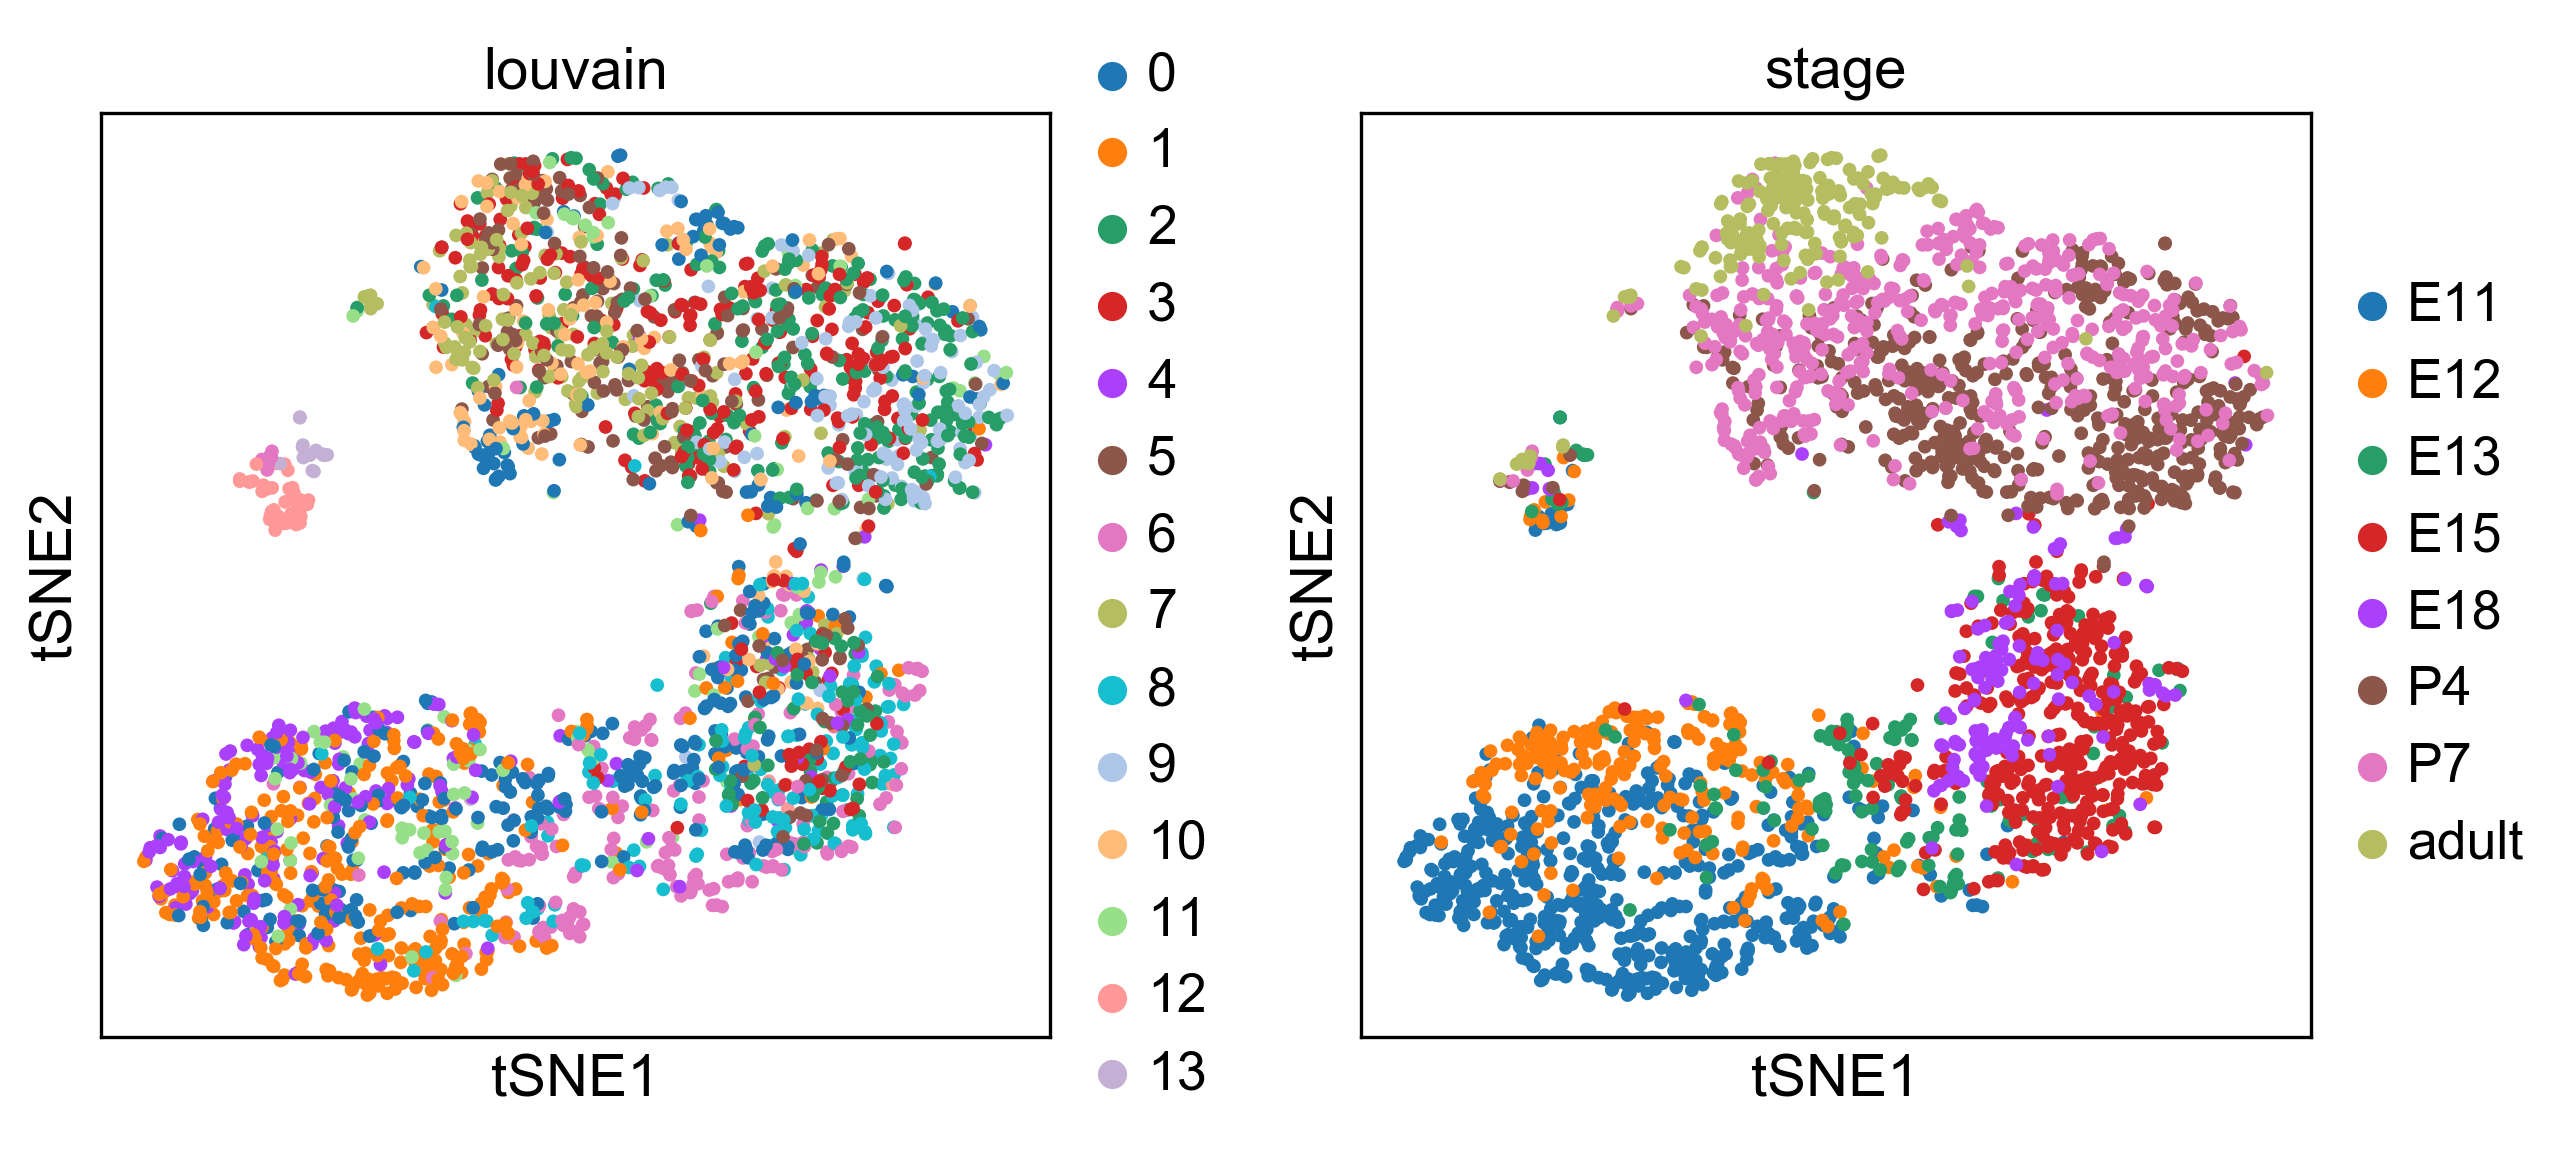

In [19]:
sc.pl.tsne(adata, color=['louvain', 'stage'])

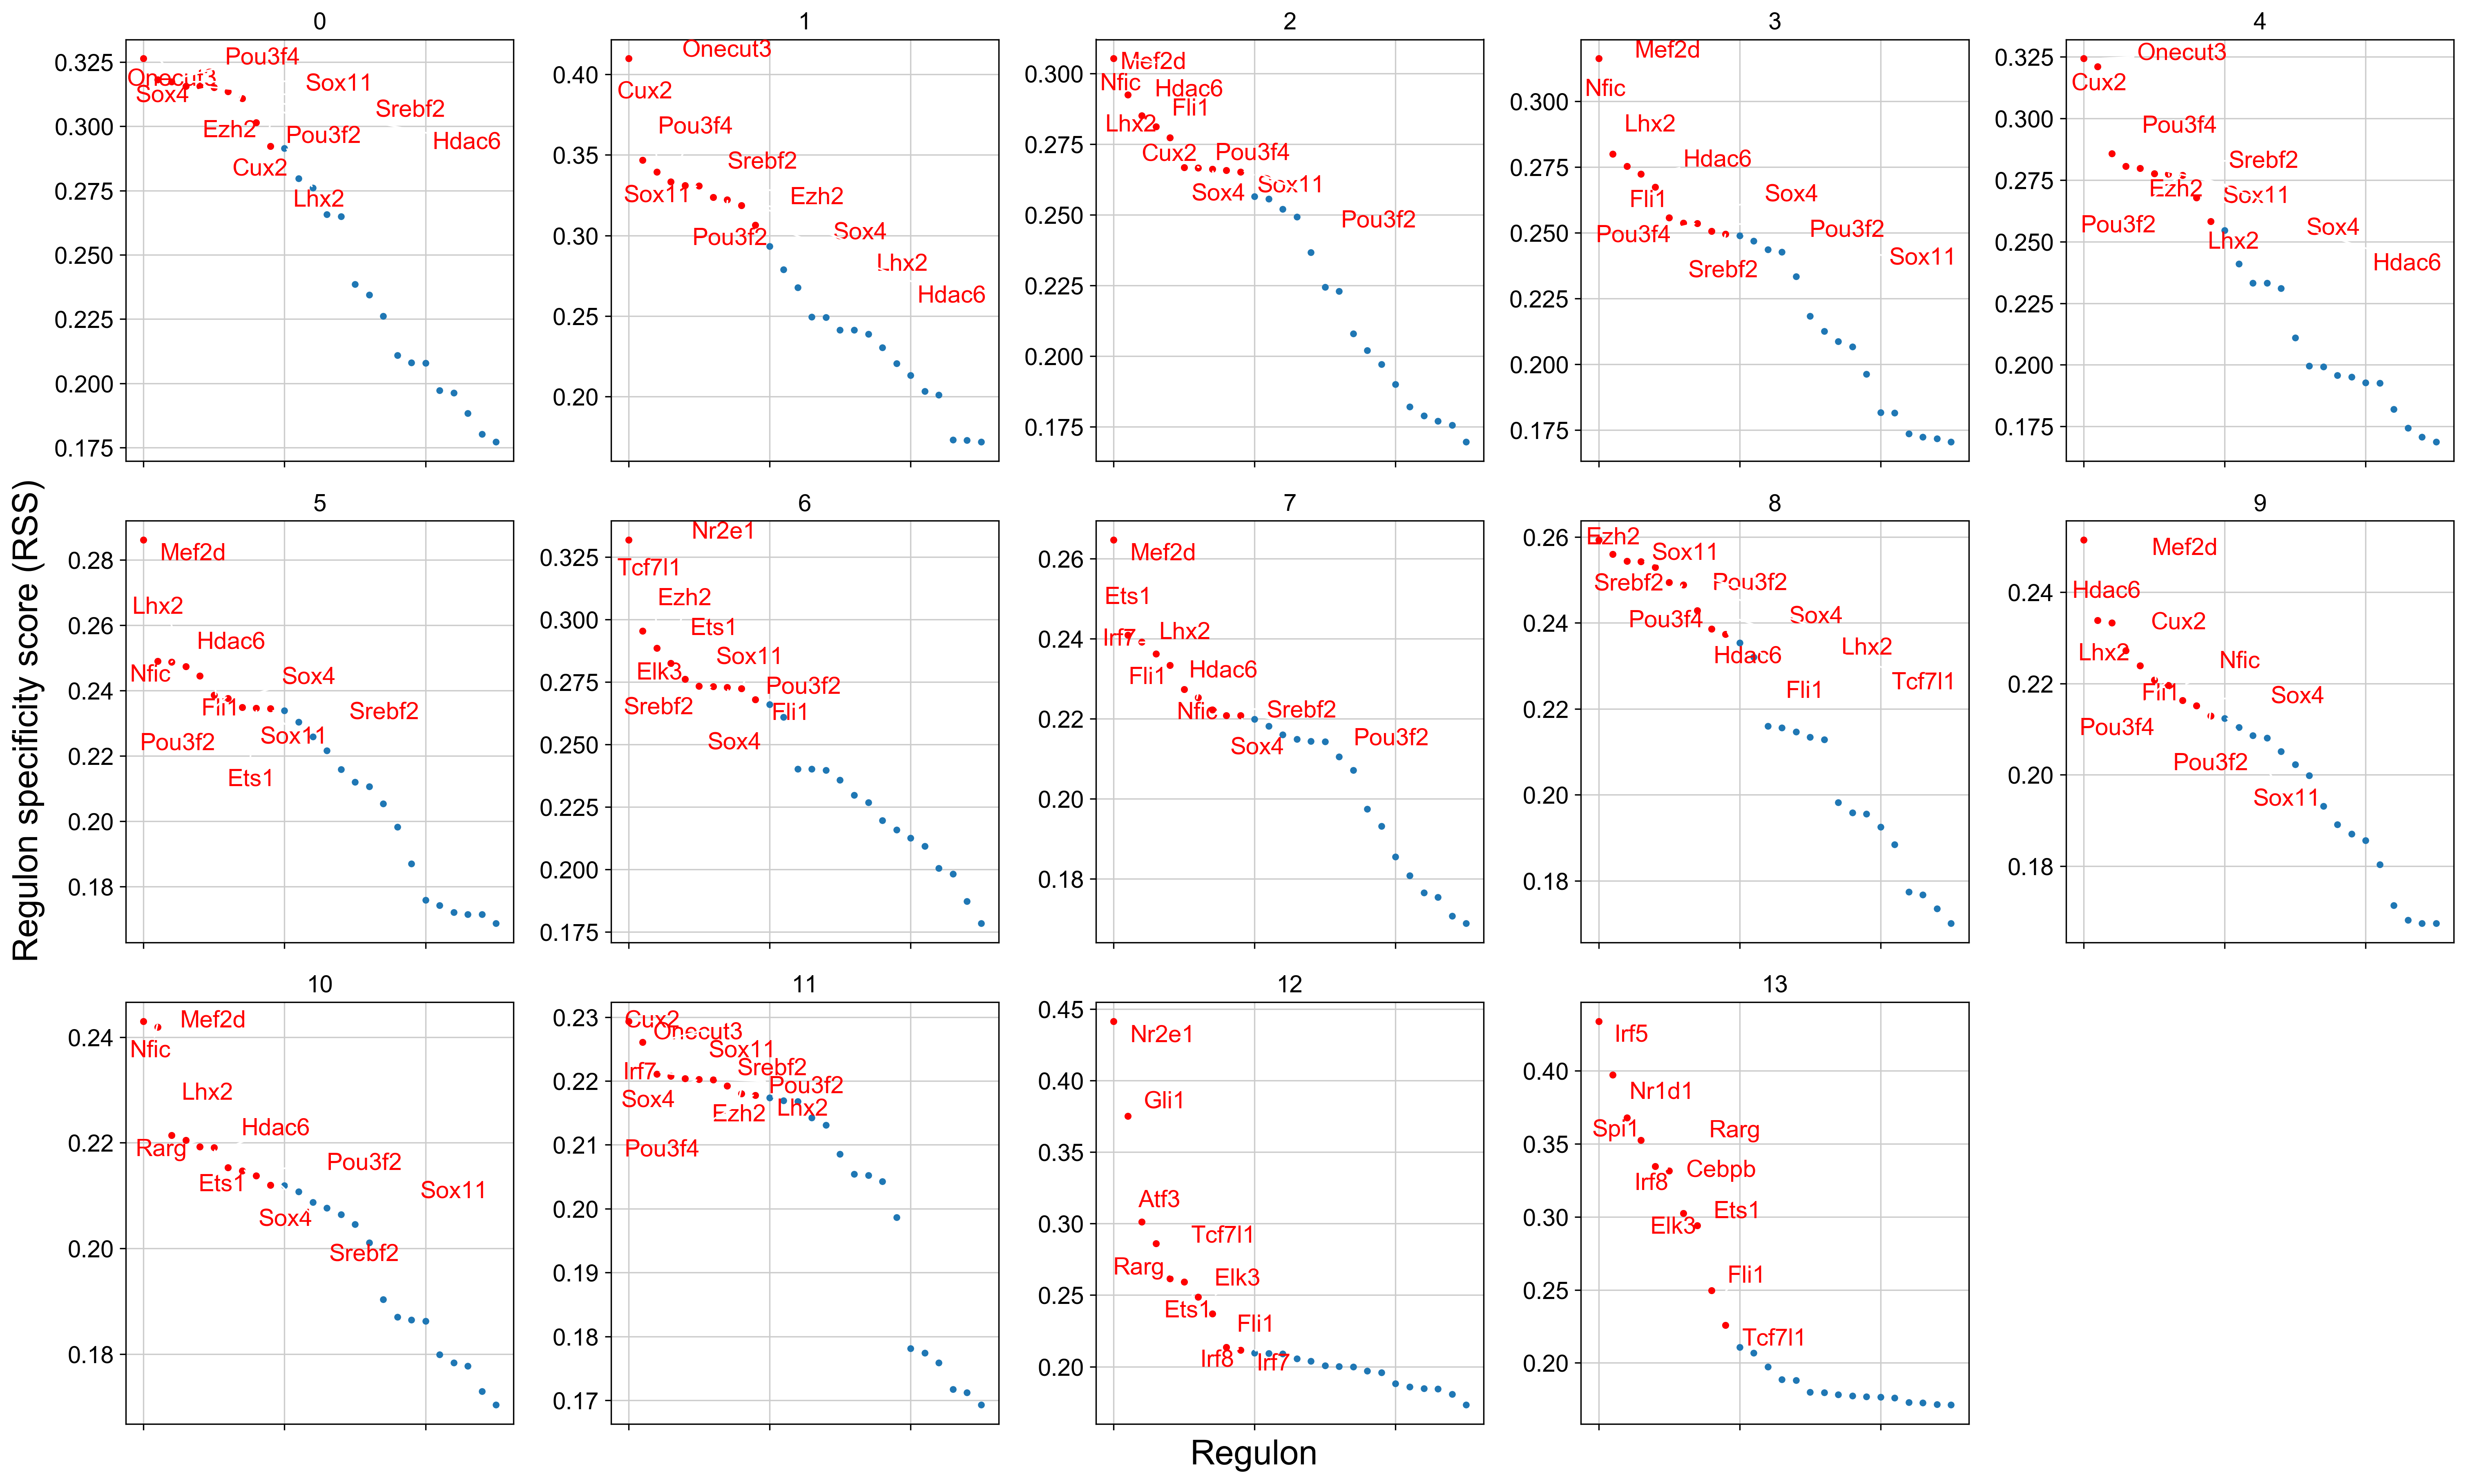

In [20]:
cats = sorted( list(set(clusters)), key=int )

fig = plt.figure(figsize=(20, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', arrowprops=dict(arrowstyle='-',color='white'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'
        })
plt.savefig("../../figures/pySCENIC/top_regulons_louvain.pdf", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [21]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [27]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

#### Generate a heatmap

In [28]:
colors=adata.uns["louvain_colors"]
#colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in clusters ] #cellAnnot['Louvain_clusters_Scanpy']

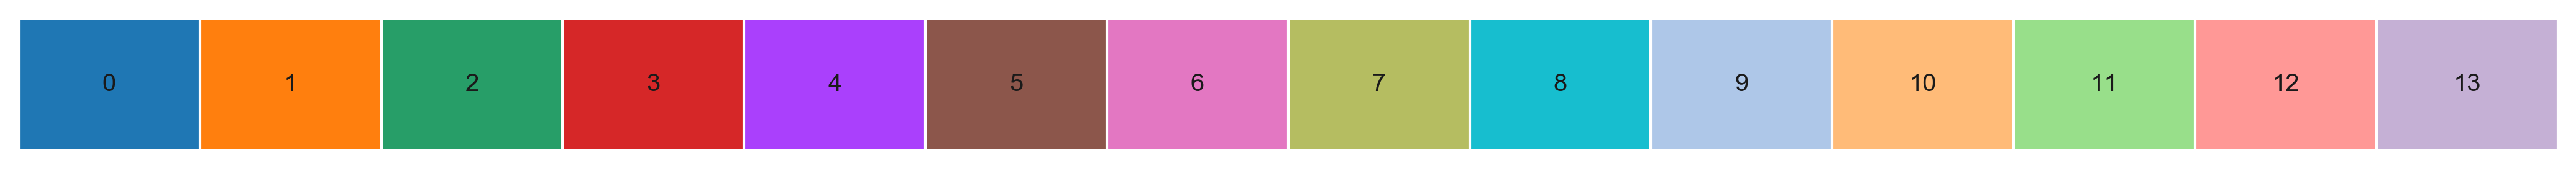

In [29]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


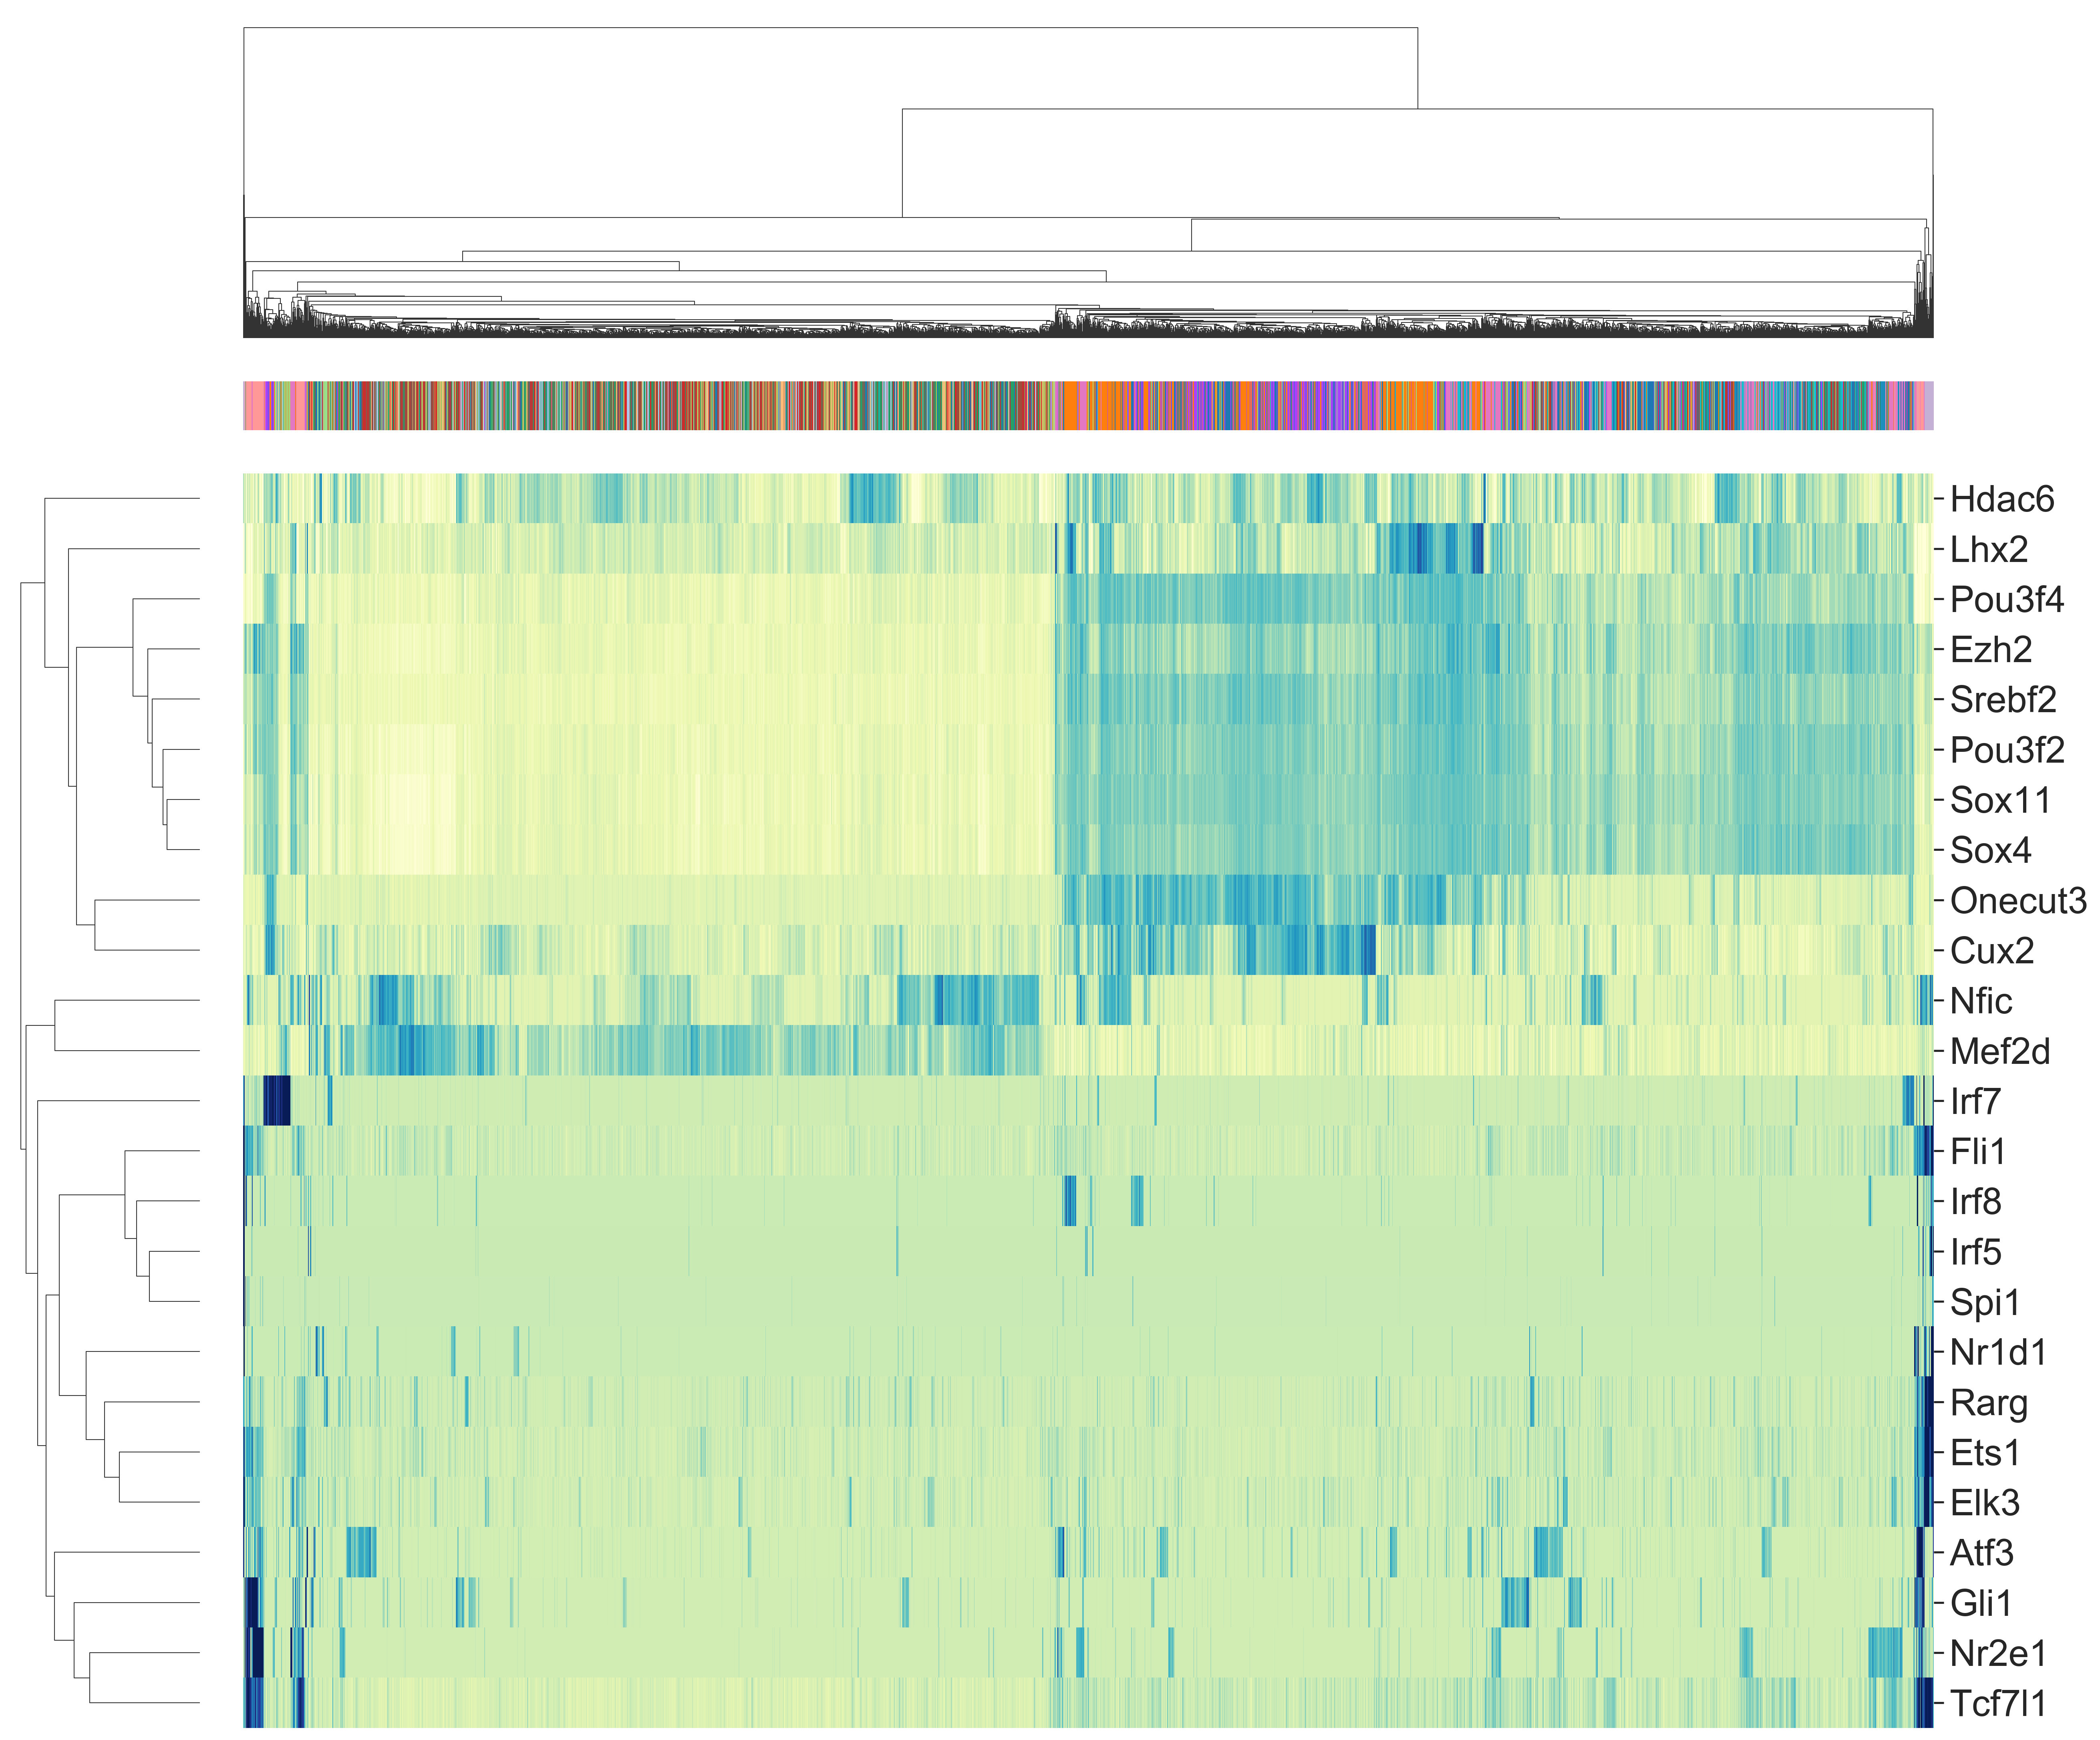

In [30]:
sns.set(font_scale=2)
g = sns.clustermap(auc_mtx_Z[topreg].T, square=False,  linecolor='black',
    xticklabels=False, vmin=-2, vmax=6, col_colors=colormap,
    cmap="YlGnBu", figsize=(18,15), dendrogram_ratio=(.1, .2), cbar_pos=None)
#g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 
g.savefig("../../figures/pySCENIC/regulon_heatmap_Z-score_louvain.pdf", dpi=100)

In [57]:
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
#sns.set(font_scale=0.9)
#g.cax.set_visible(True)
#g.ax_heatmap.set_ylabel('')    
#g.ax_heatmap.set_xlabel('')    

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Error in callback <function flush_figures at 0x1a183c9200> (for post_execute):


KeyboardInterrupt: 

In [ ]:
sns.set(font_scale=2)
g = sns.clustermap(auc_mtx_Z[topreg].T, square=False,  linecolor='black',
    xticklabels=False, vmin=-2, vmax=6, col_colors=colormap,
    cmap="YlGnBu", figsize=(18,15), dendrogram_ratio=(.1, .2), cbar_pos=None)
#g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 
g.savefig("../../figures/pySCENIC/regulon_heatmap_Z-score_louvain.pdf", dpi=100)